In [43]:
import torch
from torch import nn
import numpy as np

def MAE(output, target):
    return torch.mean(torch.abs(output - target))

def test(model, test_loader, f_dim, device, pred_len=360, ft=True, args=None):

    model.to(device)
    criterion_se = nn.MSELoss()
    criterion_mse = nn.MSELoss()
    criterion_mae = MAE

    with torch.no_grad():
        model.eval()
        test_loss_se=[]
        test_loss_mse = []
        test_loss_mae = []
        i = 0
        for i, (batch_x, batch_y, *_) in enumerate(test_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)[:, -pred_len:, :]
            batch_xy = torch.cat([batch_x, batch_y], dim=1).to(device)
            output = model(batch_x)
            if ft:
                output = output[:, -pred_len:, f_dim:]
                batch_y = batch_y[:, -pred_len:, f_dim:].to(device)
                loss_se = criterion_se(output[:,-1,:], batch_y[:,-1,:])
                loss_mse = criterion_mse(output, batch_y)
                loss_mae = criterion_mae(output, batch_y)
            else:
                output = output[:, :, f_dim:]
                loss_mse = criterion_mse(output, batch_xy)
                loss_mae = criterion_mae(output, batch_xy)

            
            test_loss_se.append(loss_se.item())
            test_loss_mse.append(loss_mse.item())
            test_loss_mae.append(loss_mae.item())
            i += 1
            if i == 50 and args.model == "ARIMA":
                break

        print(
            f"Test loss SE (mean from {i} batches) {np.mean(test_loss_se):.4f} Test loss MSE: {np.mean(test_loss_mse):.4f}, Test loss MAE: {np.mean(test_loss_mae):.4f}"
        )
        print("args =", args)

    return model, np.mean(test_loss_mse), output, batch_xy, batch_x, batch_y

In [44]:
import torch
from FITS_datahandling.data_factory import data_provider
from models.FITS_padding import FITS
from argparse import Namespace

args = Namespace(root_path='data', dataset='GD', debug=False, target_columns=['OT'], all_cols=True, epochs=50, batch_size=64, test_size=0.1, normalize=True, seq_len=720, num_layers=1, num_hidden=64, label_len=48, pred_len=720, individual=False, upsample_rate=0, channels=7, dominance_freq=196, augment_data=False,  aug_method='f_mix', features='M', use_wandb=False, ft=False, train_and_finetune=True, H_order=6, base_T=24, use_real_FITS=False, use_original_datahandling=True,  test_only=False, model='FITS_padding', save_state_dict=True, use_deep=False, data='GD', target=['OT'], data_size=1, test_time_train=False,  in_batch_augmentation=False, in_dataset_augmentation=False, num_workers=8, freq='h', data_path='gd.csv')

model = FITS(args)  # Replace *args and **kwargs with the appropriate arguments for your model
saved_model = "model_FITS_padding_data_GD_pred720__pred__epochs50.pth"
state_dict = torch.load(f'../src/saved_models/{saved_model}')
model.load_state_dict(state_dict)

test_data, test_loader = data_provider(args, "test")

model, test_mse, output, batch_xy, batch_x, batch_y= test(
    model=model,
    test_loader=test_loader,
    pred_len=args.pred_len,
    f_dim=-1 if args.features == "MS" else 0,
    device="cpu",
    ft=True,
    args=args,
)


Length of test set: 2425
Test loss SE (mean from 38 batches) 31.9399 Test loss MSE: 11.8740, Test loss MAE: 2.5756
args = Namespace(root_path='../data', dataset='GD', debug=False, target_columns=['OT'], all_cols=True, epochs=50, batch_size=64, test_size=0.1, normalize=True, seq_len=720, num_layers=1, num_hidden=64, label_len=48, pred_len=720, individual=False, upsample_rate=0, channels=7, dominance_freq=196, augment_data=False, aug_method='f_mix', features='M', use_wandb=False, ft=False, train_and_finetune=True, H_order=6, base_T=24, use_real_FITS=False, use_original_datahandling=True, test_only=False, model='FITS_padding', save_state_dict=True, use_deep=False, data='GD', target=['OT'], data_size=1, test_time_train=False, in_batch_augmentation=False, in_dataset_augmentation=False, num_workers=8, freq='h', data_path='gd.csv')


In [45]:
from models.baseline import NaiveForecast
from models.baseline import AverageForecast
from parser import parser # type: ignore    

pred_len = args.pred_len
seq_len = args.seq_len

# Initialize the baseline models and FITS
args_ = parser.parse_args(["--pred_len", str(pred_len), "--seq_len", str(seq_len), "--debug"])
naive = NaiveForecast(args_)
average = AverageForecast(args_)

def RMAE(output, target):
    return torch.sqrt(torch.mean(torch.abs(output - target)))

criterion_mse = nn.MSELoss()

# Naive Forecast
with torch.no_grad():
    output_naive = naive(batch_x)
    if type(output_naive) == torch.tensor: output_naive = output_naive.detach().numpy()
    output_naive = output_naive[:, -pred_len:, :]
    loss_mse_naive = criterion_mse(output_naive, batch_y)

# Average Forecast
with torch.no_grad():
    output_average = average(batch_x)
    if type(output) == torch.tensor: output_average = output_average.detach().numpy()
    output_average = output_average[:, -pred_len:, 0:]
    loss_mse_average = criterion_mse(output_average, batch_y)

ARIMA takes too long to calculate on all batches so it's left out below:

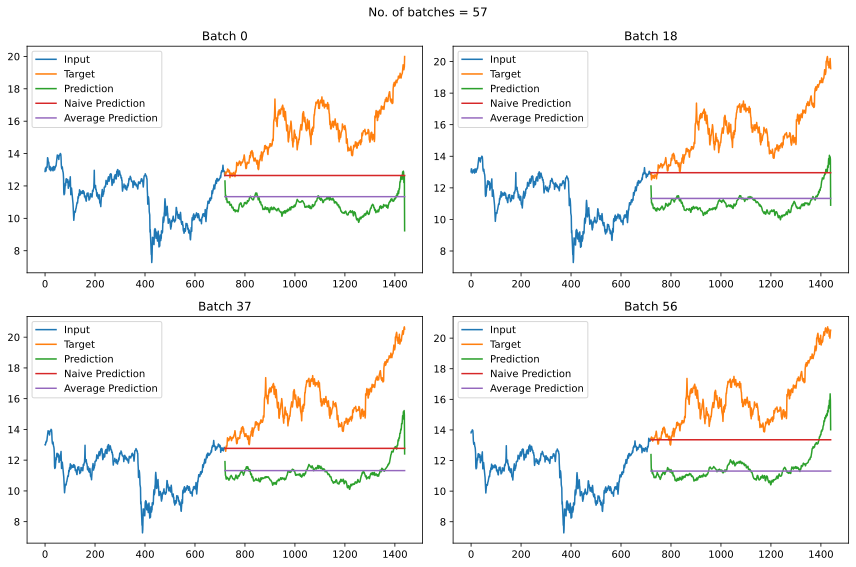

In [46]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

pred_len = args.pred_len
seq_len = args.seq_len
cutoff_freq = args.dominance_freq

num_plots = 4
fig, axs = plt.subplots(num_plots//2, 2, figsize=(12, num_plots*2))
axs = axs.flatten()

for i in range(num_plots):
    batch = i * (output.shape[0] - 1) // (num_plots - 1)

    seq_len = batch_xy.shape[1] - pred_len
    axs[i].plot(range(seq_len), batch_xy[batch, :seq_len, 0].cpu().numpy(), label="Input")
    axs[i].plot(range(seq_len, seq_len + pred_len), batch_y[batch, :, 0].cpu().numpy(), label="Target")
    axs[i].plot(range(seq_len, seq_len + pred_len), output[batch, :, 0].cpu().numpy(), label="Prediction")
    axs[i].plot(range(seq_len, seq_len + pred_len), output_naive[batch, :, 0].cpu().numpy(), label="Naive Prediction")
    axs[i].plot(range(seq_len, seq_len + pred_len), output_average[batch, :, 0].cpu().numpy(), label="Average Prediction")
    axs[i].set_title(f"Batch {batch}")
    axs[i].legend()

plt.suptitle(f"No. of batches = {output.shape[0]}")
plt.tight_layout()
plt.show()

In [47]:
batch_x = batch_x[0, :, 0].clone().unsqueeze(0).unsqueeze(-1)
batch_y = batch_y[0, :, 0].clone().unsqueeze(0).unsqueeze(-1)
batch_xy = batch_xy[0, :, 0].clone().unsqueeze(0).unsqueeze(-1)


In [48]:
from models.ARIMA import ARIMA
from models.baseline import NaiveForecast
from models.baseline import AverageForecast
from parser import parser # type: ignore    

# Initialize the baseline models and FITS
args_ = parser.parse_args(["--pred_len", str(pred_len), "--seq_len", str(seq_len), "--debug"])
arima = ARIMA(args_)
naive = NaiveForecast(args_)
average = AverageForecast(args_)

def RMAE(output, target):
    return torch.sqrt(torch.mean(torch.abs(output - target)))

criterion_mse = nn.MSELoss()


# Naive Forecast
with torch.no_grad():
    output_naive = naive(batch_x)
    if type(output_naive) == torch.tensor: output_naive = output_naive.detach().numpy()
    output_naive = output_naive[:, -pred_len:, :]
    loss_mse_naive = criterion_mse(output_naive, batch_y)

# Average Forecast
with torch.no_grad():
    output_average = average(batch_x)
    if type(output_average) == torch.tensor: output_average = output_average.detach().numpy()
    output_average = output_average[:, -pred_len:, 0:]
    loss_mse_average = criterion_mse(output_average, batch_y)

# ARIMA Forecast
with torch.no_grad():
    output_arima, best_model = arima(batch_x)
    output_arima = output_arima.to(batch_y.device)
    if type(output_arima) == torch.tensor: output_arima = output_arima.detach().numpy()
    output_arima = output_arima[:, -pred_len:, 0:]
    loss_mse_arima= criterion_mse(output_arima, batch_y)

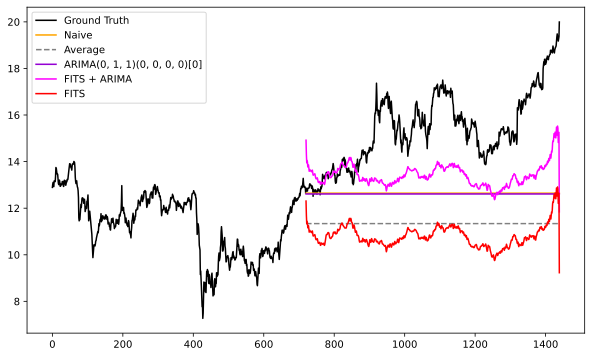

In [49]:
output_arima_fits = output + output_arima - torch.mean(output)
loss_mse_arima_fits = criterion_mse(output_arima_fits, batch_y)

plt.figure(figsize=(10, 6))
seq_len = batch_xy.shape[1] - pred_len
plt.plot(range(pred_len), batch_xy[0, :seq_len, 0].cpu().numpy(), color="black", label="Ground Truth")
plt.plot(range(seq_len, seq_len + pred_len), batch_y[0, :, 0].cpu().numpy(), color='black')
plt.plot(range(seq_len, seq_len + pred_len), output_naive[0, :, 0].cpu().numpy(), label="Naive", color='orange')
plt.plot(range(seq_len, seq_len + pred_len), output_average[0, :, 0].cpu().numpy(), label="Average", color='gray', linestyle='--')
plt.plot(range(seq_len, seq_len + pred_len), output_arima[0, :, 0].cpu().numpy(), label=f"{best_model[0]}", color='darkviolet')
plt.plot(range(seq_len, seq_len + pred_len), output_arima_fits[0, :, 0].cpu().numpy(), label="FITS + ARIMA", color='magenta')
plt.plot(range(seq_len, seq_len + pred_len), output[0, :, 0].cpu().numpy(), label="FITS", color='red')
plt.legend()

plt.show()

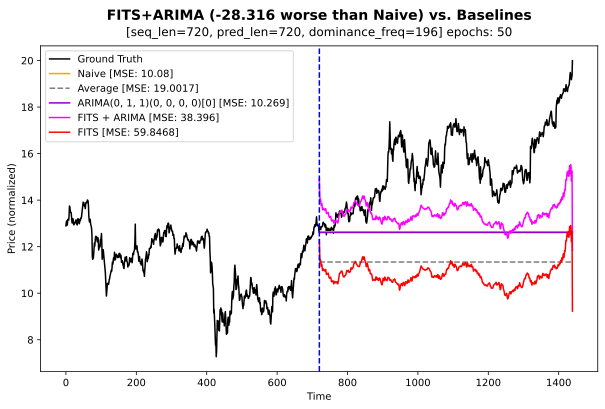

In [50]:
pred_len = args.pred_len
seq_len = args.seq_len
cutoff_freq = args.dominance_freq
epochs = args.epochs

plt.figure(figsize=(10, 6))
ax = plt.gca()

seq_len = batch_xy.shape[1] - pred_len
ax.plot(range(pred_len), batch_xy[0, :seq_len, 0].cpu().numpy(), color="black", label="Ground Truth")
ax.plot(range(seq_len, seq_len + pred_len), batch_y[0, :, 0].cpu().numpy(), color='black')

baselines = [
    ("Naive", output_naive, criterion_mse(output_naive, batch_y), 'orange', '-'),
    ("Average", output_average, criterion_mse(output_average, batch_y), 'gray', '--'),
    (best_model[0], output_arima, criterion_mse(output_arima, batch_y), 'darkviolet', '-'),
    ("FITS + ARIMA", output_arima_fits, loss_mse_arima_fits, 'magenta', '-'),
    ("FITS", output, criterion_mse(output, batch_y), 'red', '-')
]

for name, output_data, mse, color, linestyle in baselines:
    mse_ = round(mse.item(), 4)
    ax.plot(range(seq_len, seq_len + pred_len), output_data[0, :, 0].cpu().numpy(),
            label=f"{name} [MSE: {mse_}]", color=color, linestyle=linestyle)

best = min(criterion_mse(output_naive, batch_y), criterion_mse(output_average, batch_y), criterion_mse(output_arima, batch_y))
second_best_name = next(name for name, _, mse, _, _ in baselines if mse == best)
improvement = best - loss_mse_arima_fits

ax.legend(loc="upper left")
ax.axvline(x=seq_len, color="blue", linestyle="--", label="Forecast Start")

ax.set_title(" ", fontsize=40)
ax.text(0.5, 1.08, f"""FITS+ARIMA ({'+' if round(improvement.item(), 5) >= 0 else '-'}{abs(round(improvement.item(), 3))} {'better' if round(improvement.item(), 5) >= 0 else 'worse'} than {second_best_name}) vs. Baselines""", fontsize=14, ha='center', fontweight='bold', transform=ax.transAxes)
ax.text(0.5, 1.03, f"""[seq_len={seq_len}, pred_len={pred_len}, dominance_freq={cutoff_freq}] epochs: {epochs}""", fontsize=12, ha='center', transform=ax.transAxes)

ax.set_ylabel("Price (normalized)")
ax.set_xlabel("Time")

plt.show()